##### Image dataset: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset?resource=download
##### Metainfo csv: https://github.com/lgreski/pokemonData/blob/master/Pokemon.csv
##### You can speed up model inference on colab by changing Hardware accelerator in runtime type to any GPU option

In [1]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3ol3wuay
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3ol3wuay
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=c393d60e4c7fd59c73d5ff74d6fd

In [2]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [3]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/MyDrive/219/Pokemon.csv'
image_dir = '/content/drive/MyDrive/219/images'

Mounted at /content/drive


In [5]:
pokedex = construct_pokedex(csv_path=csv_path, image_dir=image_dir)

In [6]:
[model, preprocess, device] = load_clip_model()

100%|███████████████████████████████████████| 890M/890M [00:10<00:00, 92.4MiB/s]


In [7]:
image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"], device)

100%|██████████| 753/753 [50:54<00:00,  4.06s/it]


QUESTION 26: Try to construct various text queries regarding types of Pokemon (such as ”type: Bug”, ”electric type Pok´emon” or ”Pok´emon with fire abilities”) to find the relevant images from the dataset. Once you have found the most suitable template for queries, please find the top five
most relevant Pokemon for type Bug, Fire and Grass. For each of the constructed query, please plot the five most relevant Pokemon horizontally in one figure with following specifications:
- the title of the figure should be the query you used;
- the title of each Pokemon should be the name of the Pokemon and its first and second type.

Repeat this process for Pokemon of Dark and Dragon types. Assess the effectiveness of your queries in these cases as well and try to explain any differences.

In [12]:
def query_search_image_return(text,num_top_images=5):
  text_embeddings = clip_inference_text(model, preprocess, text, device)
  cosine_similarities = compute_similarity_image_to_text(image_embeddings, text_embeddings)
  cosine_similarities = np.squeeze(cosine_similarities)
  top_image_indices = np.argsort(cosine_similarities)[::-1][:num_top_images]

  fig, axs = plt.subplots(1, num_top_images, figsize=(8, 2))
  for i in np.arange(num_top_images):
    plt.sca(axs[i])
    image_path = pokedex["image_path"][top_image_indices[i]]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    type1 = pokedex["Type1"][top_image_indices[i]]
    type2 = pokedex["Type2"][top_image_indices[i]]
    if type2 == '':
      plt.title(type1 + " only ")
    else:
      plt.title(type1 + " & " + type2)
  title = "The query: " + text
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

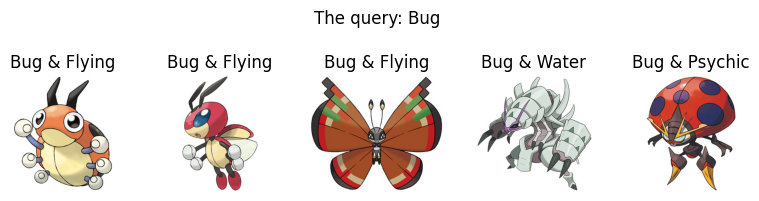

In [13]:
query_search_image_return("Bug")

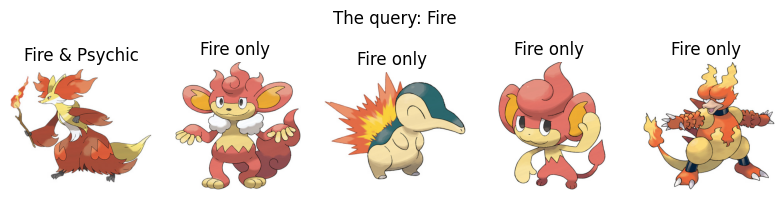

In [14]:
query_search_image_return("Fire")

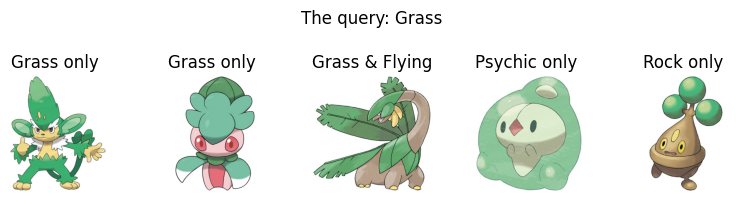

In [15]:
query_search_image_return("Grass")

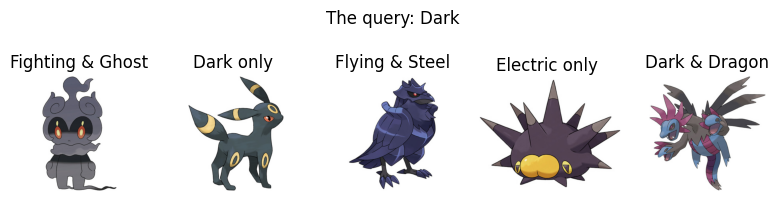

In [16]:
query_search_image_return("Dark")

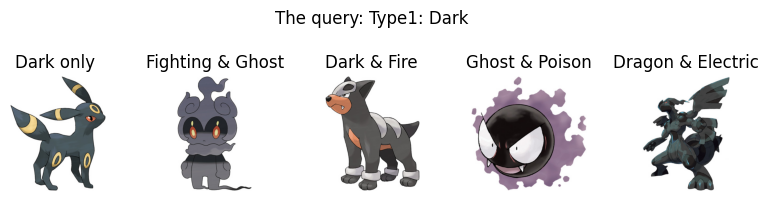

In [17]:
query_search_image_return("Type1: Dark")

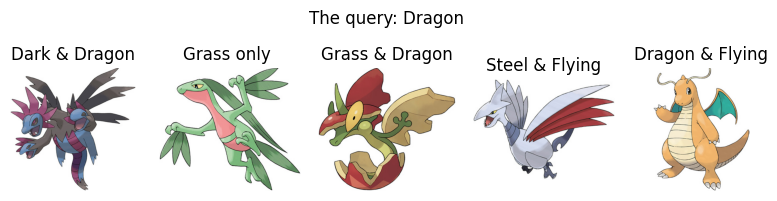

In [18]:
query_search_image_return("Dragon")

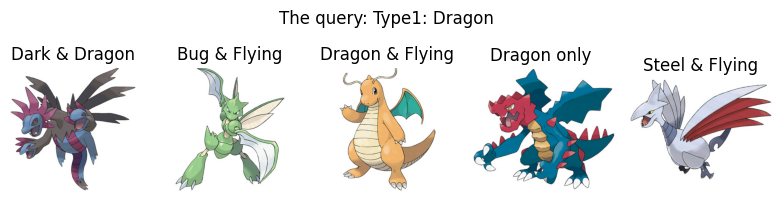

In [19]:
query_search_image_return("Type1: Dragon")

Answer: For the Bug, Fire, and Grass types, finding corresponding images is straightforward as these types have distinct and recognizable visual representations. It's interesting to note that when querying for "Grass" alone, it displays two different types, namely Psychic and Rock. Upon closer inspection, these Pokémon share a green color and a visual resemblance to grass. When refining the query to "Type1: Grass," the search exclusively shows Pokémon with Grass type as their primary classification. However, challenges arise for Dark and Dragon types. Dark may be interpreted as a descriptor for color, making it less visually distinguishable, while Dragon might denote an overall appearance characteristic rather than a specific visual trait. Hence, the difficulty in locating images for Dark and Dragon types can be attributed to the abstract or subjective nature of these descriptors.

QUESTION 27: Randomly select 10 Pokemon images from the dataset and use CLIP to find the most relevant types (use your preferred template, e.g ”type: Bug”). For each selected Pokemon, please plot it and indicate:
- its name and first and second type;
- the five most relevant types predicted by CLIP and their predicted probabilities.

In [20]:
import random
random.seed(22)
random_idx = [random.randint(1, len(pokedex["image_path"])) for _ in range(10)]

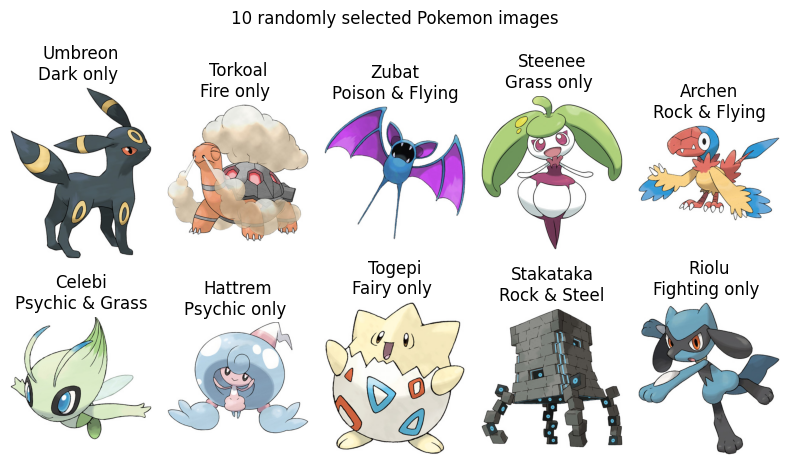

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(8, 5))
for i in np.arange(10):
  row = i // 5
  col = i % 5
  plt.sca(axs[row,col])
  image_path = pokedex["image_path"][random_idx[i]]
  image = Image.open(image_path)
  plt.imshow(image)
  plt.axis('off')
  name = pokedex["Name"][random_idx[i]]
  type1 = pokedex["Type1"][random_idx[i]]
  type2 = pokedex["Type2"][random_idx[i]]
  if type2 == '':
    plt.title(name+ "\n" + type1 + " only ")
  else:
    plt.title(name+ "\n" + type1 + " & " + type2)
title = "10 randomly selected Pokemon images"
plt.suptitle(title)
plt.tight_layout()
plt.show()

In [23]:
types_set = ["Normal","Fire","Water", "Electric","Grass","Ice","Fighting","Poison","Ground","Flying","Psychic","Bug","Rock","Ghost","Dragon","Dark","Steel","Fairy"]
text_embeddings_set = []
for i in np.arange(len(types_set)):
  text_embeddings = clip_inference_text(model, preprocess, types_set[i], device)
  text_embeddings = np.squeeze(text_embeddings)
  text_embeddings_set.append(text_embeddings)
text_embeddings_set = np.array(text_embeddings_set)
cosine_similarities_selected = compute_similarity_image_to_text(image_embeddings, text_embeddings_set)[random_idx]

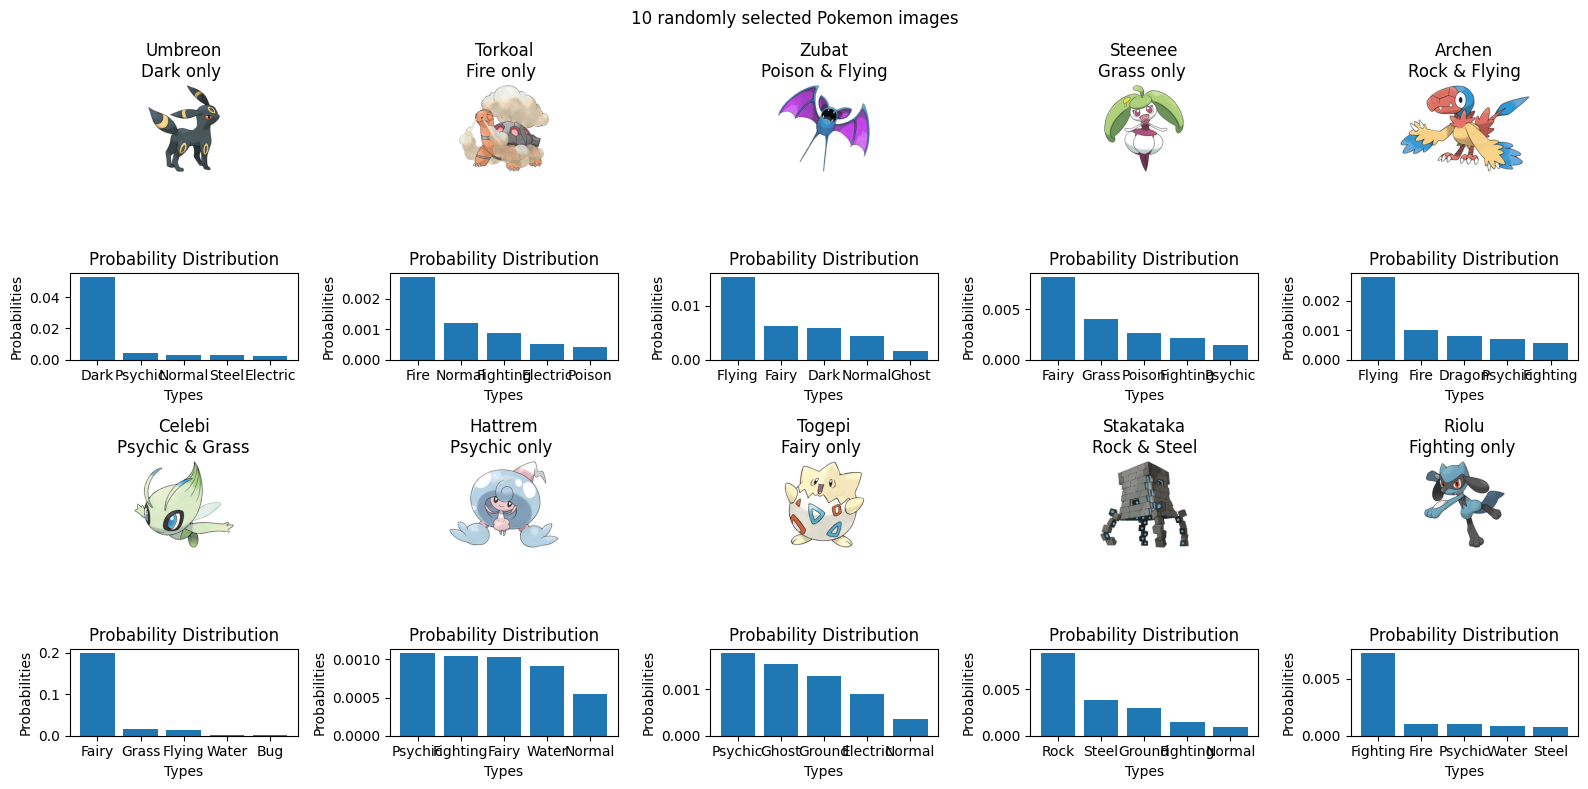

In [25]:
width_ratios = [1, 1, 1, 1, 1]
height_ratios = [1,1,1,1]
fig, axs = plt.subplots(4, 5, gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios}, figsize=(16, 8))
for i in np.arange(20):
  row = i // 5
  col = i % 5

  plt.sca(axs[row,col])
  idx = (row//2)*5+col

  if row%2==0:

    image_path = pokedex["image_path"][random_idx[idx]]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    name = pokedex["Name"][random_idx[idx]]
    type1 = pokedex["Type1"][random_idx[idx]]
    type2 = pokedex["Type2"][random_idx[idx]]
    if type2 == '':
      plt.title(name+ "\n" + type1 + " only ")
    else:
      plt.title(name+ "\n" + type1 + " & " + type2)
  else:

    cosine_similarities_selected_k = cosine_similarities_selected[idx]
    #cosine_similarities_selected_k = cosine_similarities_selected_k/sum(cosine_similarities_selected_k)*100
    #cosine_similarities_selected_k = softmax(cosine_similarities_selected_k)*100
    top_image_indices = np.argsort(cosine_similarities_selected_k)[::-1][:5]
    probabilities = cosine_similarities_selected_k[top_image_indices]

    types_set = np.array(types_set)
    labels = types_set[top_image_indices]

    plt.bar(labels, probabilities)
    plt.title('Probability Distribution')
    plt.xlabel('Types')
    plt.ylabel('Probabilities')

title = "10 randomly selected Pokemon images"
plt.suptitle(title)
plt.tight_layout()
plt.show()

Analysis: All the inferences are based on the images, and as a result, types directly related to visual appearance show higher accuracy and more confident predictions. For example, Umbreon, being a Dark-type, has a prediction accuracy of over 50%, which aligns with the dark color of its appearance. Stakataka, with its blocky rock-like structure, achieves nearly 100% accuracy in the Rock type prediction. Torkoal presents an interesting case where the gases it emits are mispredicted as Ice, likely due to their white color, while its shell is  identified as Rock. For Pokémon with appearance characteristics that don't strongly indicate a specific type, like Hattrem, the Psychic type becomes more challenging to determine. In summary, the model tends to perform better when visual characteristics strongly correlate with specific Pokémon types.

QUESTION 28: In the first and second question, we investigated how CLIP creates ’clusters’ by mapping images and texts of various Pokemon into a high-dimensional space and explored neighborhood of these items in this space. For this question, please use t-SNE to visualize image clusters, specifically for Pokemon types Bug, Fire, and Grass. You can use scatter plot from python package plotly. For the visualization, color-code each point based on its first type type 1 using the ’color’ argument, and label each point with the Pokemon’s name and types using ’hover name’. This will enable you to identify each Pokemon represented in your visualization. After completing the visualization, analyze it and discuss whether the clustering of Pokemon types make sense to you.

In [26]:
[num,feature] = pokedex.shape
idx = []
for i in np.arange(num):
  if (pokedex["Type1"][i] == 'Grass') or (pokedex["Type1"][i] =='Fire') or (pokedex["Type1"][i] =='Bug') or (pokedex["Type2"][i] == 'Grass') or (pokedex["Type2"][i] =='Fire') or (pokedex["Type2"][i] =='Bug'):
    idx.append(i)
image_embeddings_new = image_embeddings[idx]
visualization_data = umap_projection(image_embeddings_new, n_neighbors=15, min_dist=0.1, metric='cosine')

In [27]:
x_values = visualization_data[:, 0]
y_values = visualization_data[:, 1]

name = pokedex["Name"][idx]
type1 = pokedex["Type1"][idx]
type2 = pokedex["Type2"][idx]

fig = px.scatter(x=x_values, y=y_values, hover_name=name, color=type1,
                 hover_data = {'Type1': type1, 'Type2': type2},
                 title='Pokemon image clusters')

fig.update_layout(width=800, height=600)
fig.show()

Answer: The clustering of Pokemon types makes sense, as there is a clear division between Grass (blue), Fire (red), and Bug (green). The Grass type is located at the left bottom corner of the 2D visualization plot, while the Fire type is at the left top, and the Bug type is at the right bottom. There are also cases where the color represents the second type of the Pokemon. Additionally, there are Pokemon with mixed types, contributing to the overall diversity. In general, the division aligns with the known relationships between different Pokemon types.